In [1]:
import pandas as pd
import openpyxl
import os
import seaborn as sns
import matplotlib.pyplot as plt

## Combining results

In [2]:
%%bash
ls /mnt/c/Users/freek/Documents/BioSB/Internship/PangenomeProject/data/metagenome/phabox2_output

Antonio
Bert
Bob
Daniel
David
Grogu
Iris
Jeroen
Jip
Kai
Karel
Kees
Mosanena
Nefesh
Pennycat
Peter
Pistachio
Simon
Stefano
Steff22
Tiziano


In [3]:
# directories
phabox_dir ="/mnt/c/Users/freek/Documents/BioSB/Internship/PangenomeProject/data/metagenome/phabox2_output"

In [4]:
df_all = pd.DataFrame()

for sample_dir in os.listdir(phabox_dir):
    file_path = os.path.join(phabox_dir, sample_dir, "final_prediction/final_prediction_summary.tsv")

    if not os.path.exists(file_path):
        print(f"{sample_dir} does not contain a final_prediction_summary.tsv file and was excluded")
        continue
    
    df_sample = pd.read_csv(file_path, sep="\t")
    df_sample["sample_name"] = sample_dir
    df_all = pd.concat([df_all, df_sample], ignore_index=True)

display(df_all)
df_all.to_excel("/mnt/c/Users/freek/Documents/BioSB/Internship/PangenomeProject/data/metagenome/all_final_prediction_summaries.xlsx")

Nefesh does not contain a final_prediction_summary.tsv file and was excluded


,Accession,Length,Pred,Proportion,PhaMerScore,PhaMerConfidence,Lineage,PhaGCNScore,Genus,GenusCluster,Prokaryotic virus (Bacteriophages and Archaeal virus),TYPE,PhaTYPScore,Host,CHERRYScore,Method,Host_NCBI_lineage,Host_GTDB_lineage,sample_name
0,NODE_10000_length_470_cov_1.281928,470,filtered,0.00,0.0,rejected,filtered,0,NaN,NaN,N,NaN,0.0,filtered,0.00,NaN,NaN,NaN,Antonio
1,NODE_10001_length_470_cov_1.156627,470,filtered,0.00,0.0,rejected,filtered,0,NaN,NaN,N,NaN,0.0,filtered,0.00,NaN,NaN,NaN,Antonio
2,NODE_10002_length_470_cov_1.156627,470,filtered,0.00,0.0,rejected,filtered,0,NaN,NaN,N,NaN,0.0,filtered,0.00,NaN,NaN,NaN,Antonio
3,NODE_10003_length_470_cov_1.134940,470,filtered,0.00,0.0,rejected,filtered,0,NaN,NaN,N,NaN,0.0,filtered,0.00,NaN,NaN,NaN,Antonio
4,NODE_10004_length_469_cov_14.229469,469,filtered,0.00,0.0,rejected,filtered,0,NaN,NaN,N,NaN,0.0,filtered,0.00,NaN,NaN,NaN,Antonio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,NODE_997_length_473_cov_5.624402,473,filtered,0.00,0.0,rejected,filtered,0,NaN,NaN,N,NaN,0.0,filtered,0.00,NaN,NaN,NaN,Tiziano
135524,NODE_998_length_473_cov_1.351675,473,filtered,0.00,0.0,rejected,filtered,0,NaN,NaN,N,NaN,0.0,filtered,0.00,NaN,NaN,NaN,Tiziano
135525,NODE_999_length_473_cov_0.858852,473,filtered,0.00,0.0,rejected,filtered,0,NaN,NaN,N,NaN,0.0,filtered,0.00,NaN,NaN,NaN,Tiziano
135526,NODE_99_length_4826_cov_58.295116,4826,virus,0.50,0.5,medium-confidence,superkingdom:Viruses;genus:Pandoravirus,1.00;1.00;0.51;0.51;0.51;0.51,Pandoravirus,known_genus,N,NaN,0.0,species:Acanthamoeba sp.,0.51,AAI-based,NaN,NaN,Tiziano


## Preprocessing and creating general figures

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random

# Load the Excel file
file_path = "/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/data/metagenome/bacteria_abundance_normalized.xlsx"
sample_name_table = pd.read_csv("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/data/metagenome/metagenome_sample_names.tsv", sep="\t")
sample_name_table.set_index("metagenome_name", inplace=True)
# Load the data, replacing ',' with '.' in abundance values for proper numeric handling
data = pd.read_excel(file_path, converters={col: lambda x: str(x).replace(",", ".") for col in pd.read_excel(file_path).columns[1:]})

# Remove the 's__' prefix from species names in 'ln_species'
data["ln_species"] = data["ln_species"].str.replace("^s__", "", regex=True)

# Extract sample names from the first row (excluding 'ln_species')
sample_names = data.columns[1:]

# Extract species names and their abundances
species = data["ln_species"]
abundance_data = data.iloc[:, 1:].astype(float)  # Convert the abundance values to float
abundance_data.index = species  # Set species as the index

# Compute the average relative abundance for each species across all samples
average_abundance = abundance_data.mean(axis=1)

# Identify the top 10 species by average abundance and add the "Other" category
top_species = average_abundance.nlargest(10).index.tolist()
# Add an "Other" category for species not in the top 10
other_abundance = abundance_data.loc[~abundance_data.index.isin(top_species)].sum()
filtered_data = abundance_data.loc[top_species]
filtered_data.loc["Other"] = other_abundance

# Ensure no duplicate species, somehow everything gets duplicated?
filtered_data = filtered_data.groupby(level=0).sum()
filtered_data = filtered_data.div(filtered_data.sum(axis=0), axis=1)
filtered_data = filtered_data.T  # Samples as rows, species as columns
# Ensure Lactobacillus crispatus is at the bottom of the stacked bar chart
filtered_data = filtered_data[["Lactobacillus_crispatus"] + [col for col in filtered_data.columns if col != "Lactobacillus_crispatus"]]

# Annotate percentages of L. crispatus in each bar and make sure they do not overlap (in height) by adding a value depending on the previous y-value
last_n = 0
crispatus_dict = {}
for idx, sample in enumerate(filtered_data.index):
    crispatus_value = filtered_data.loc[sample, "Lactobacillus_crispatus"] * 100
    crispatus_name = sample_name_table.loc[sample].values[0]
    if crispatus_name == "Not applicable": crispatus_name = ""
    last_n = crispatus_value

    crispatus_dict[sample] = (filtered_data.loc[sample].cumsum()["Lactobacillus_crispatus"] - crispatus_value / 2 / 100) * 200

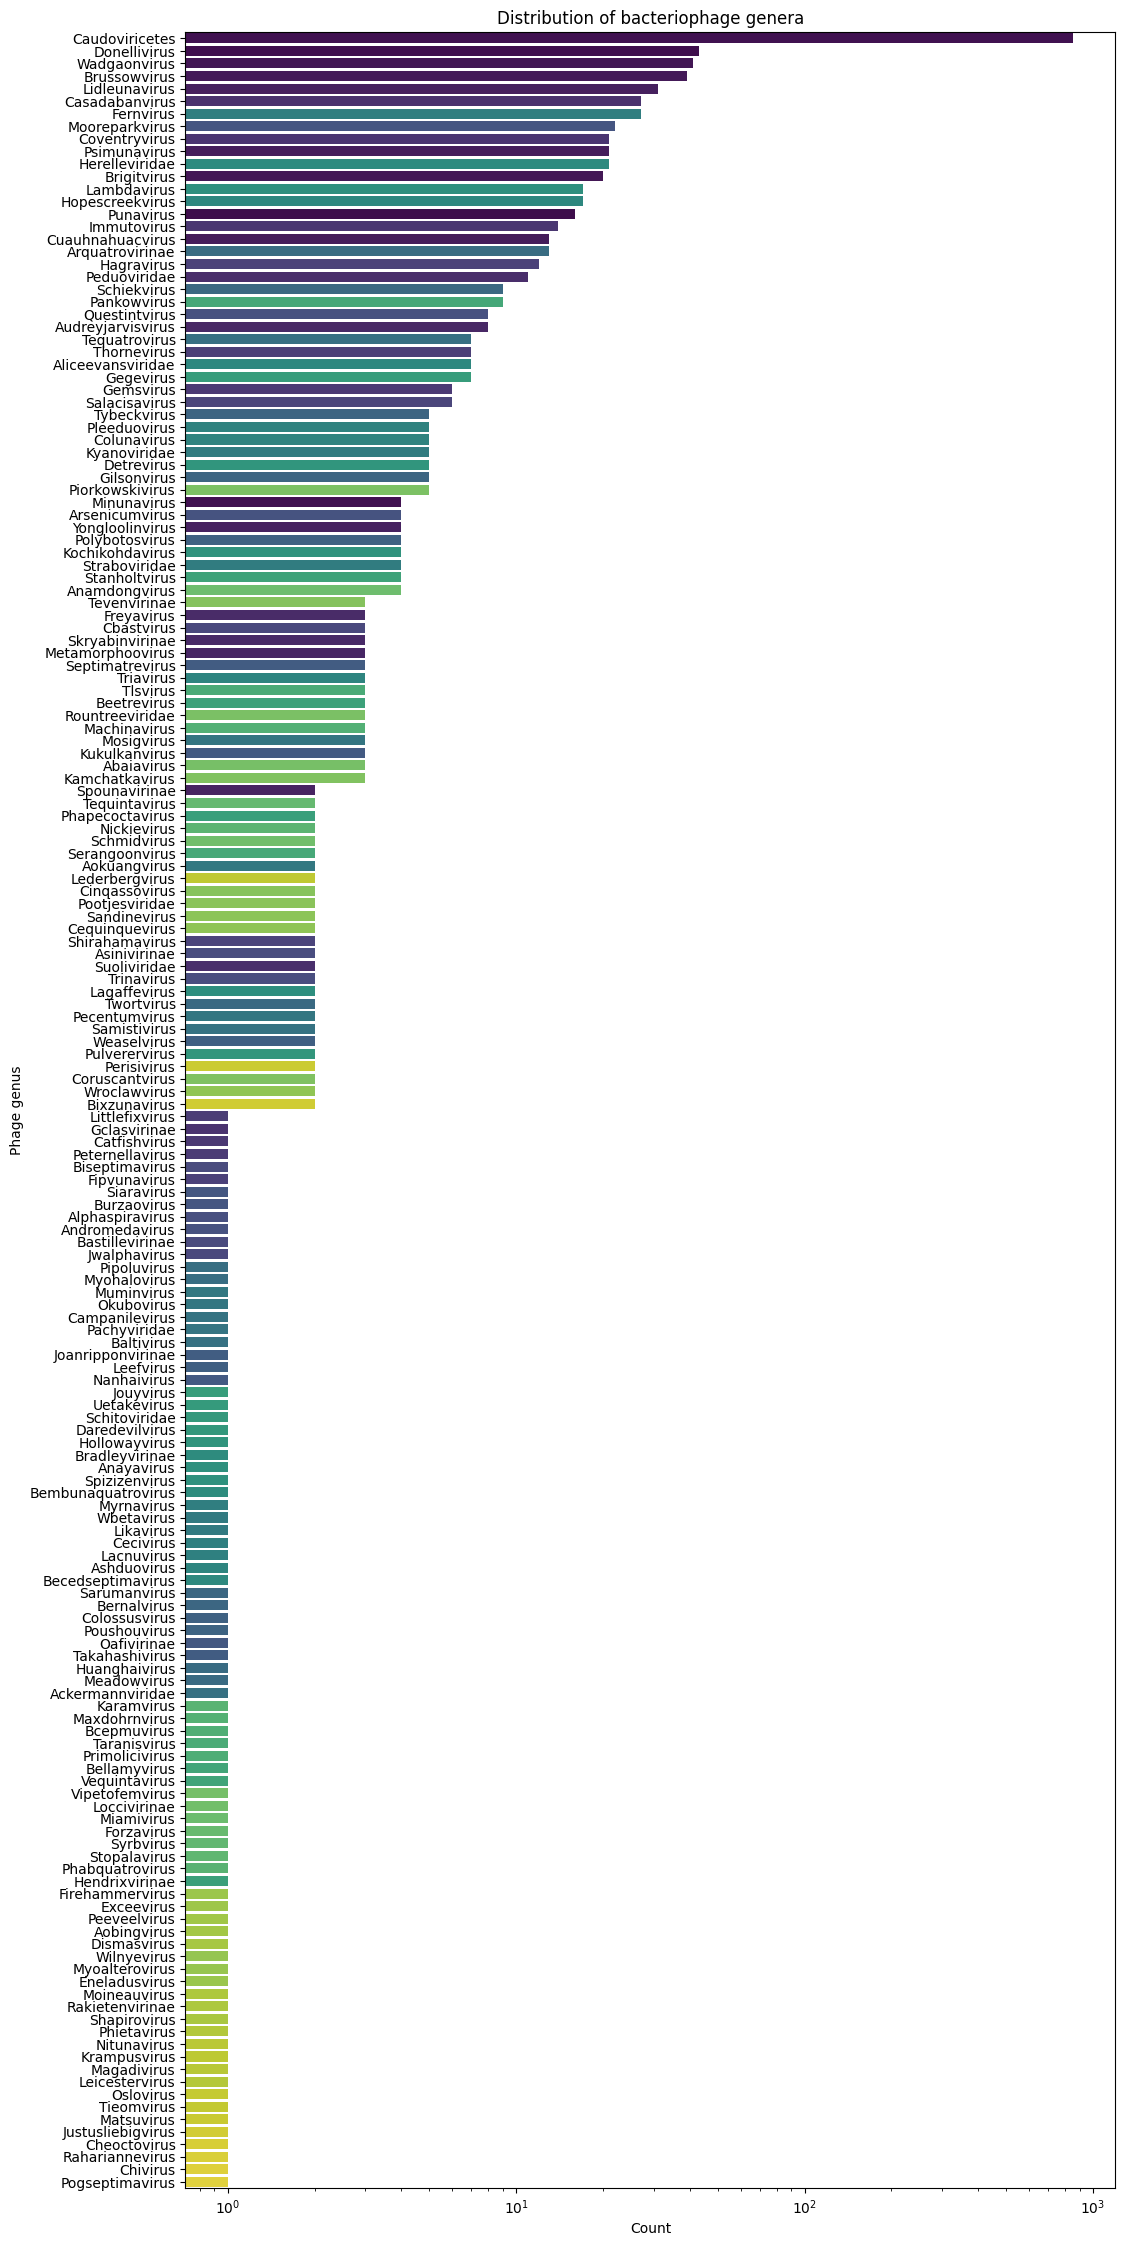

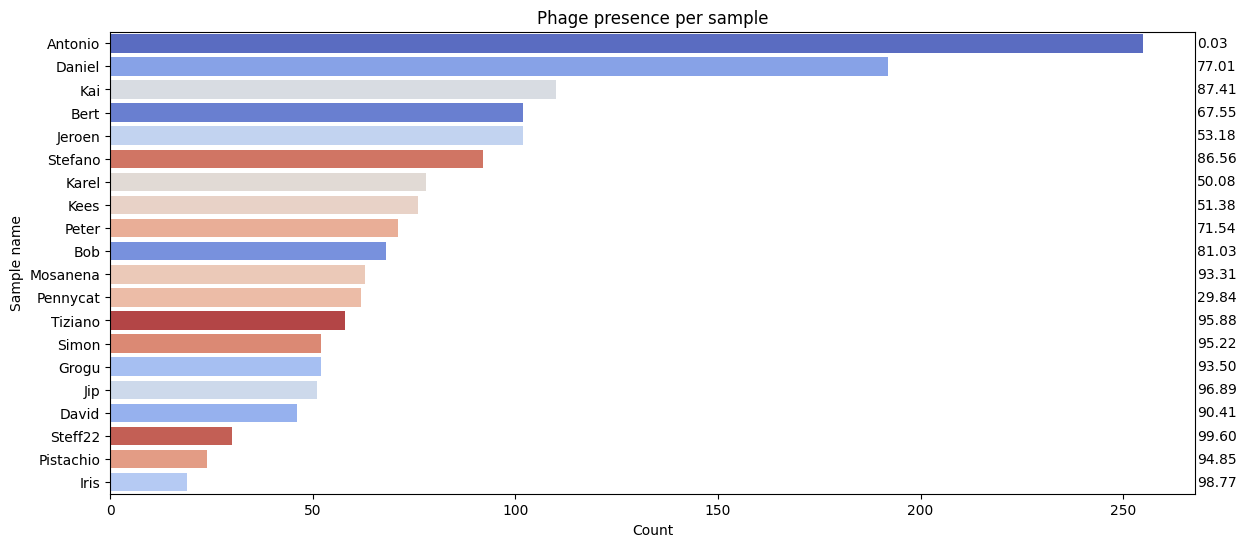

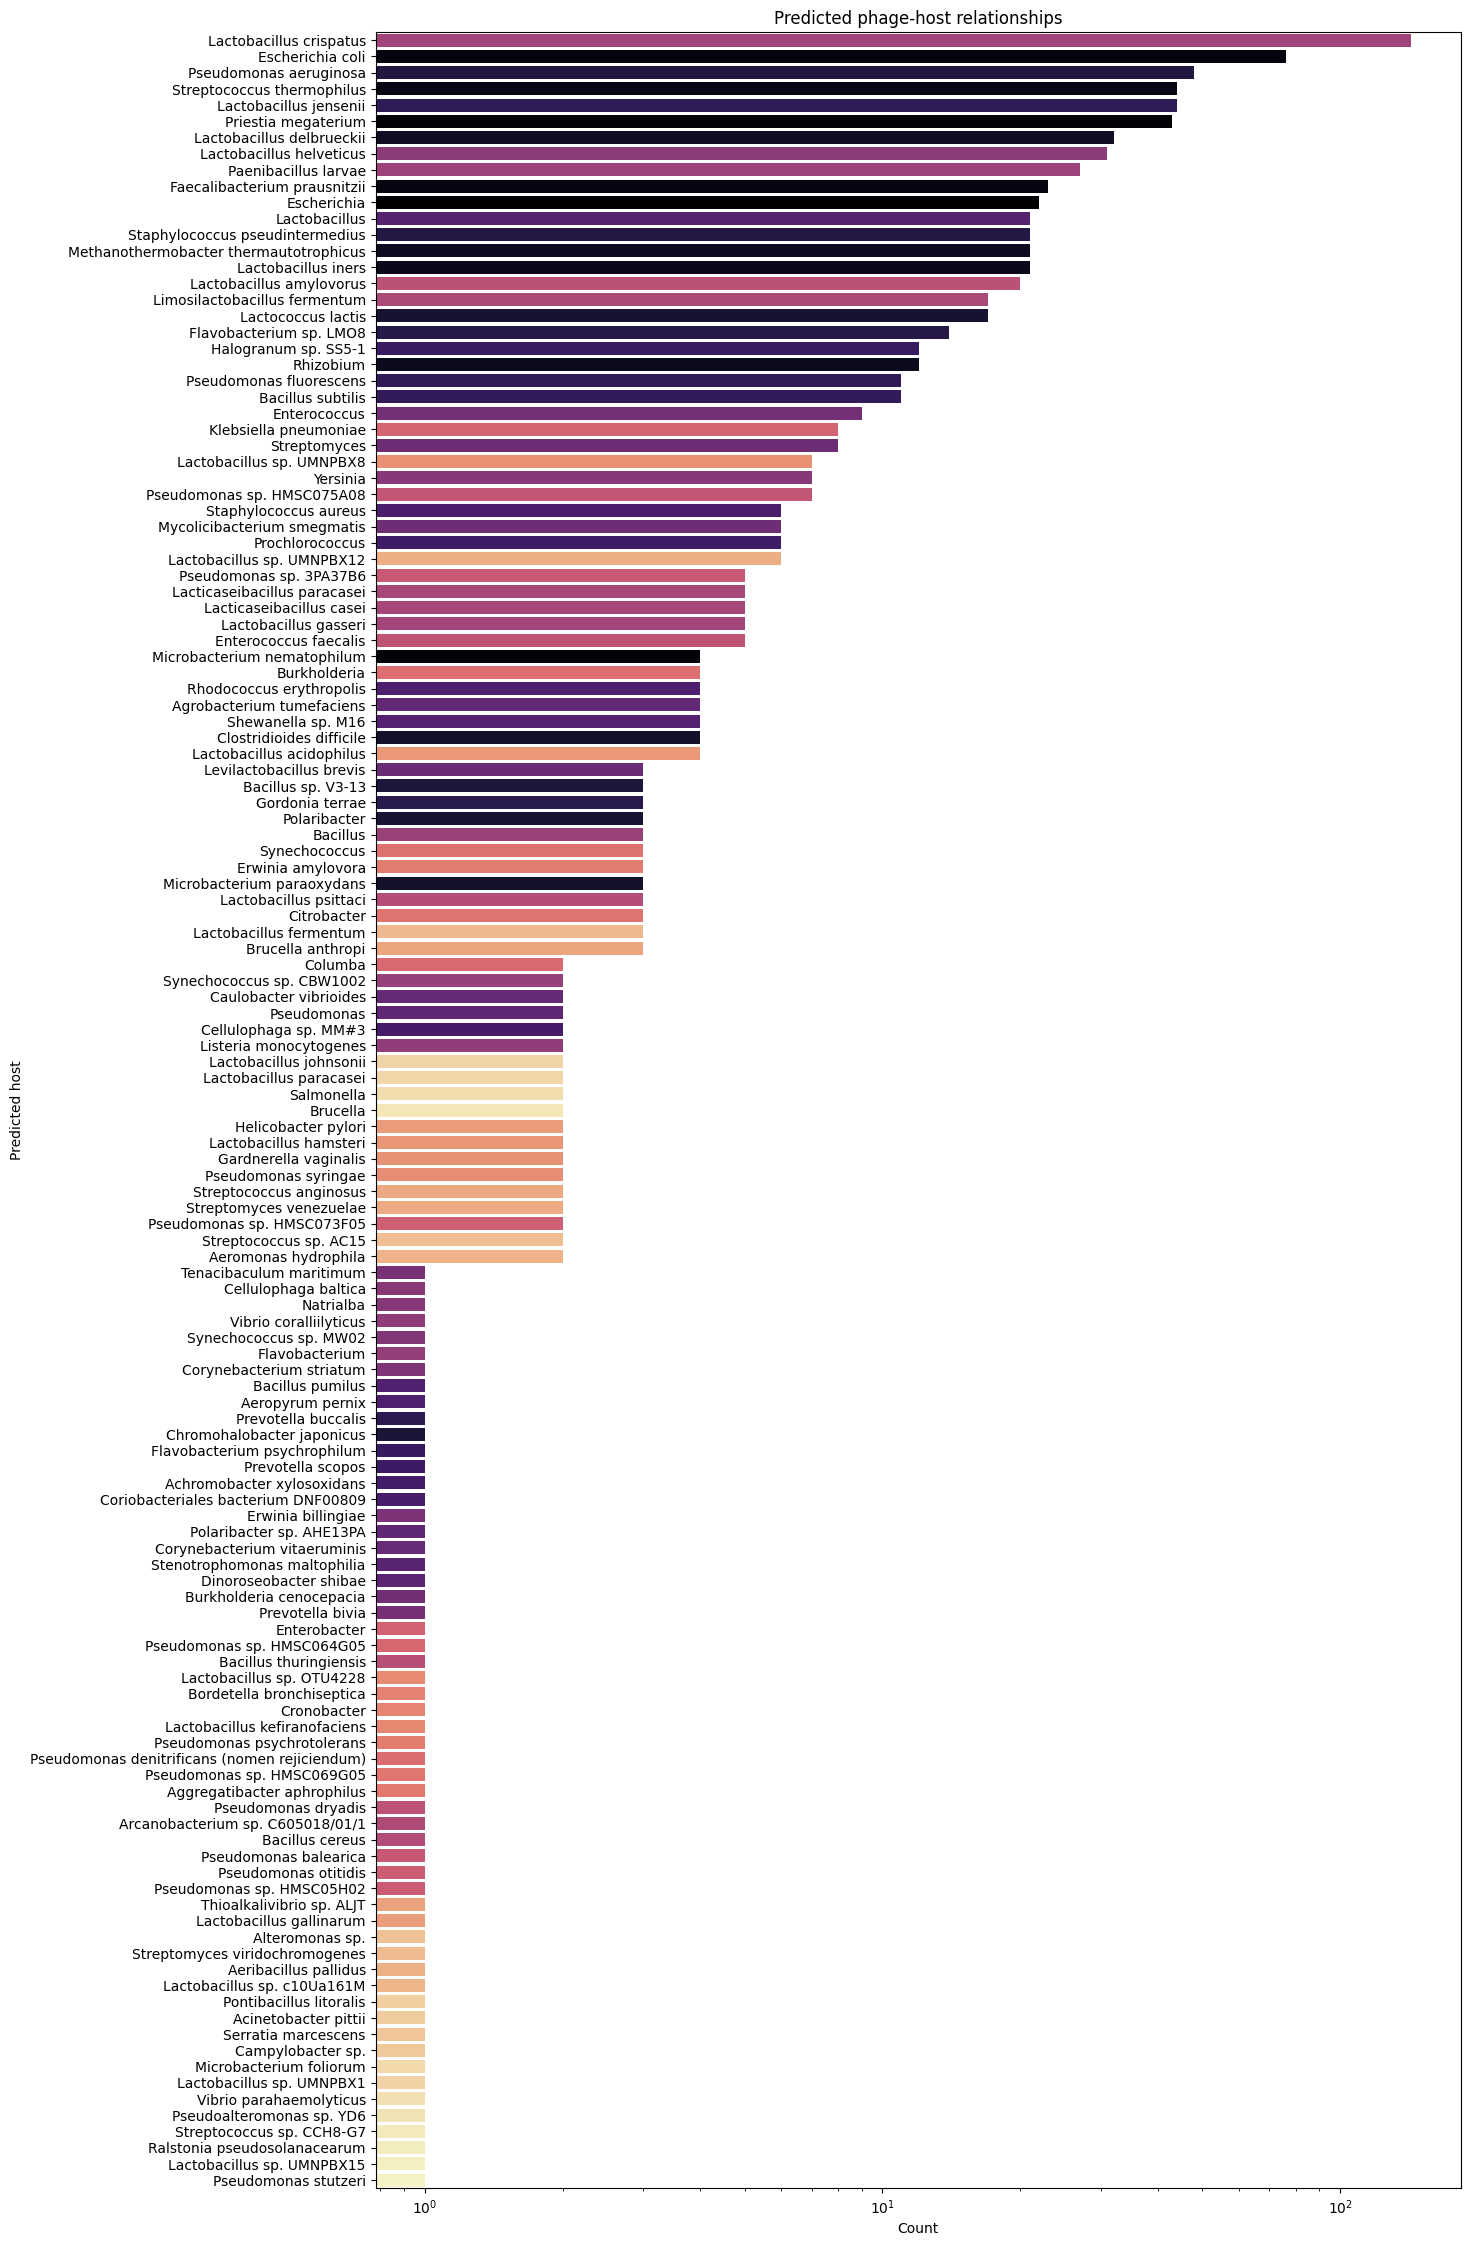

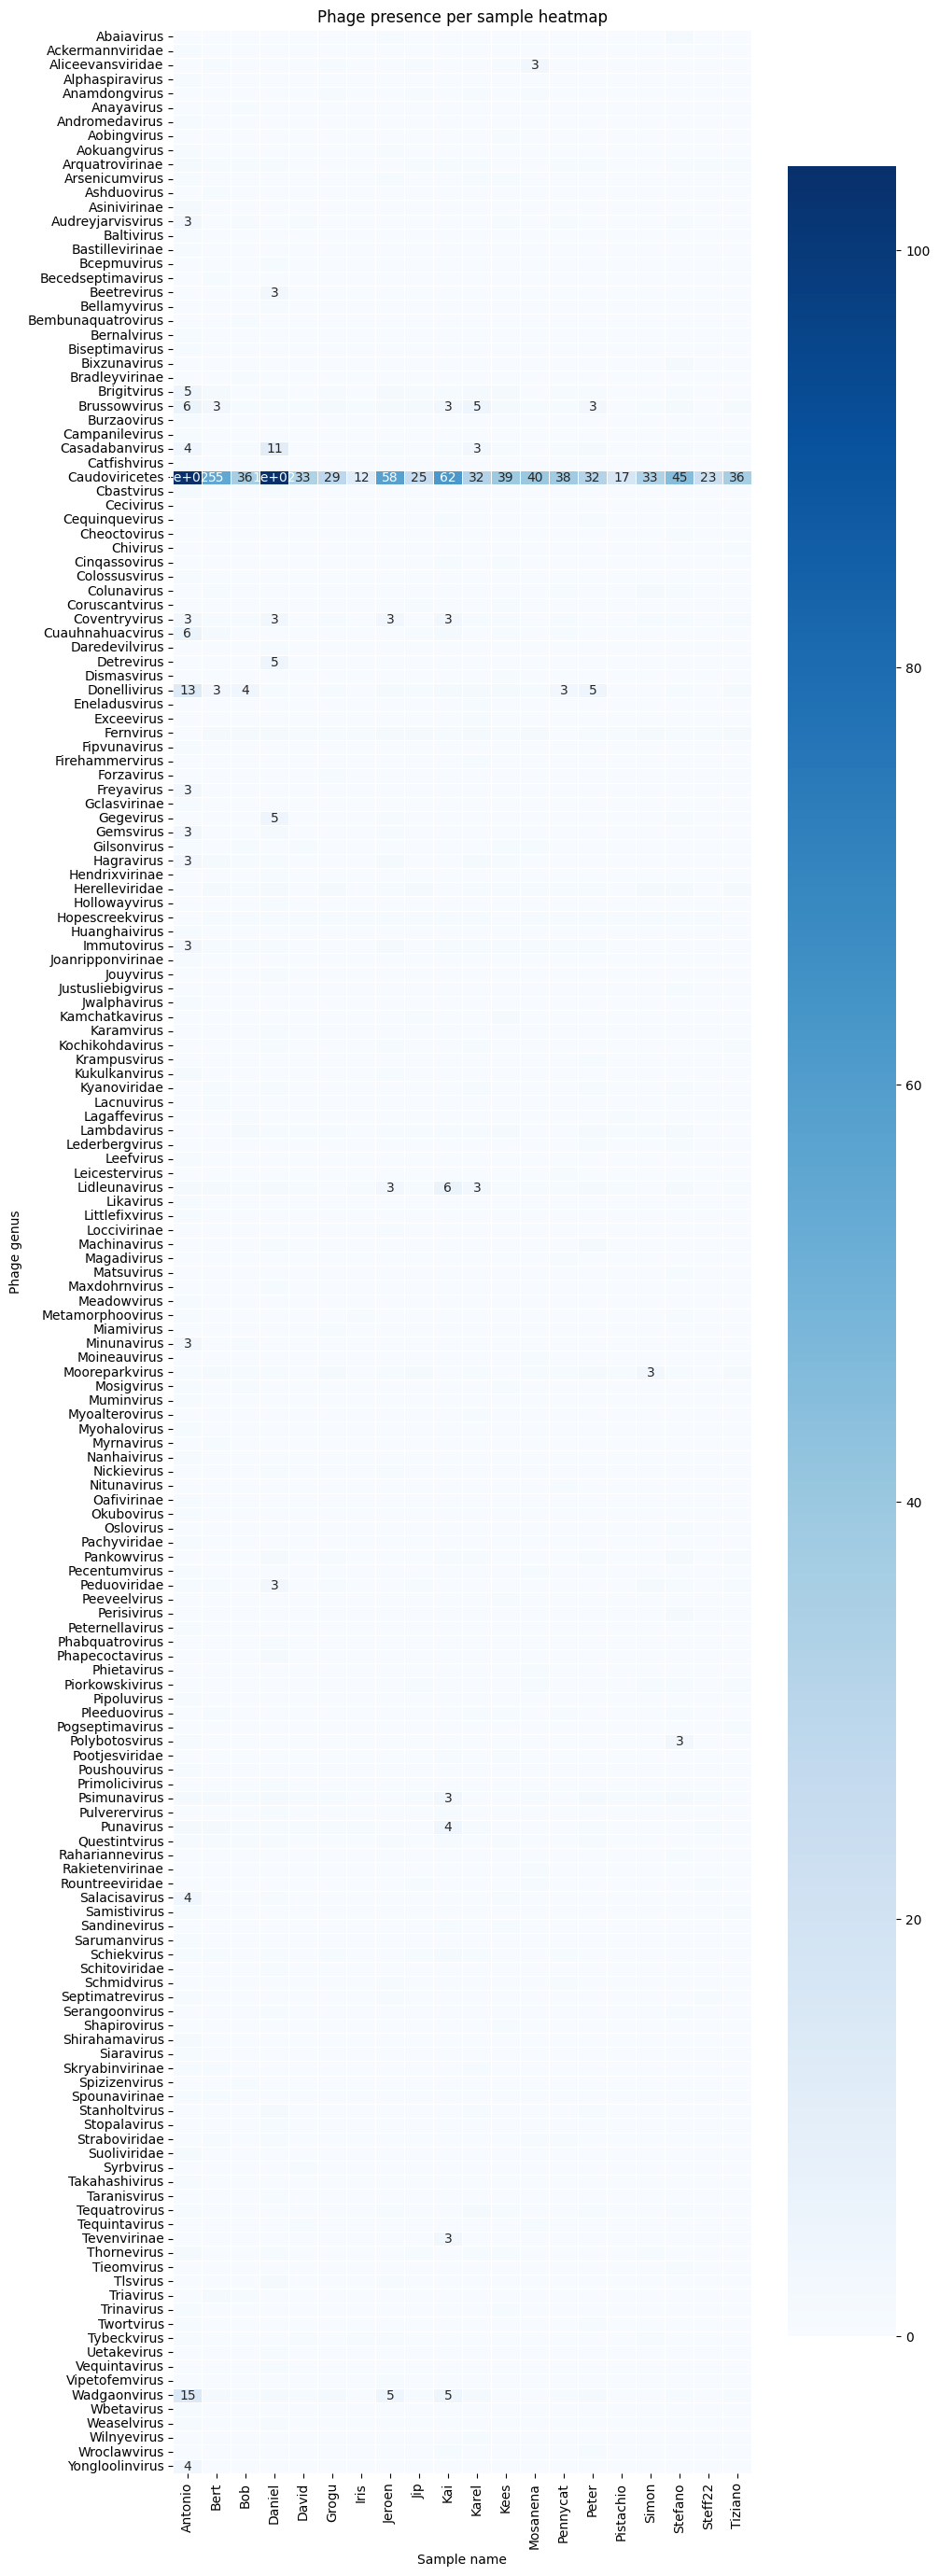

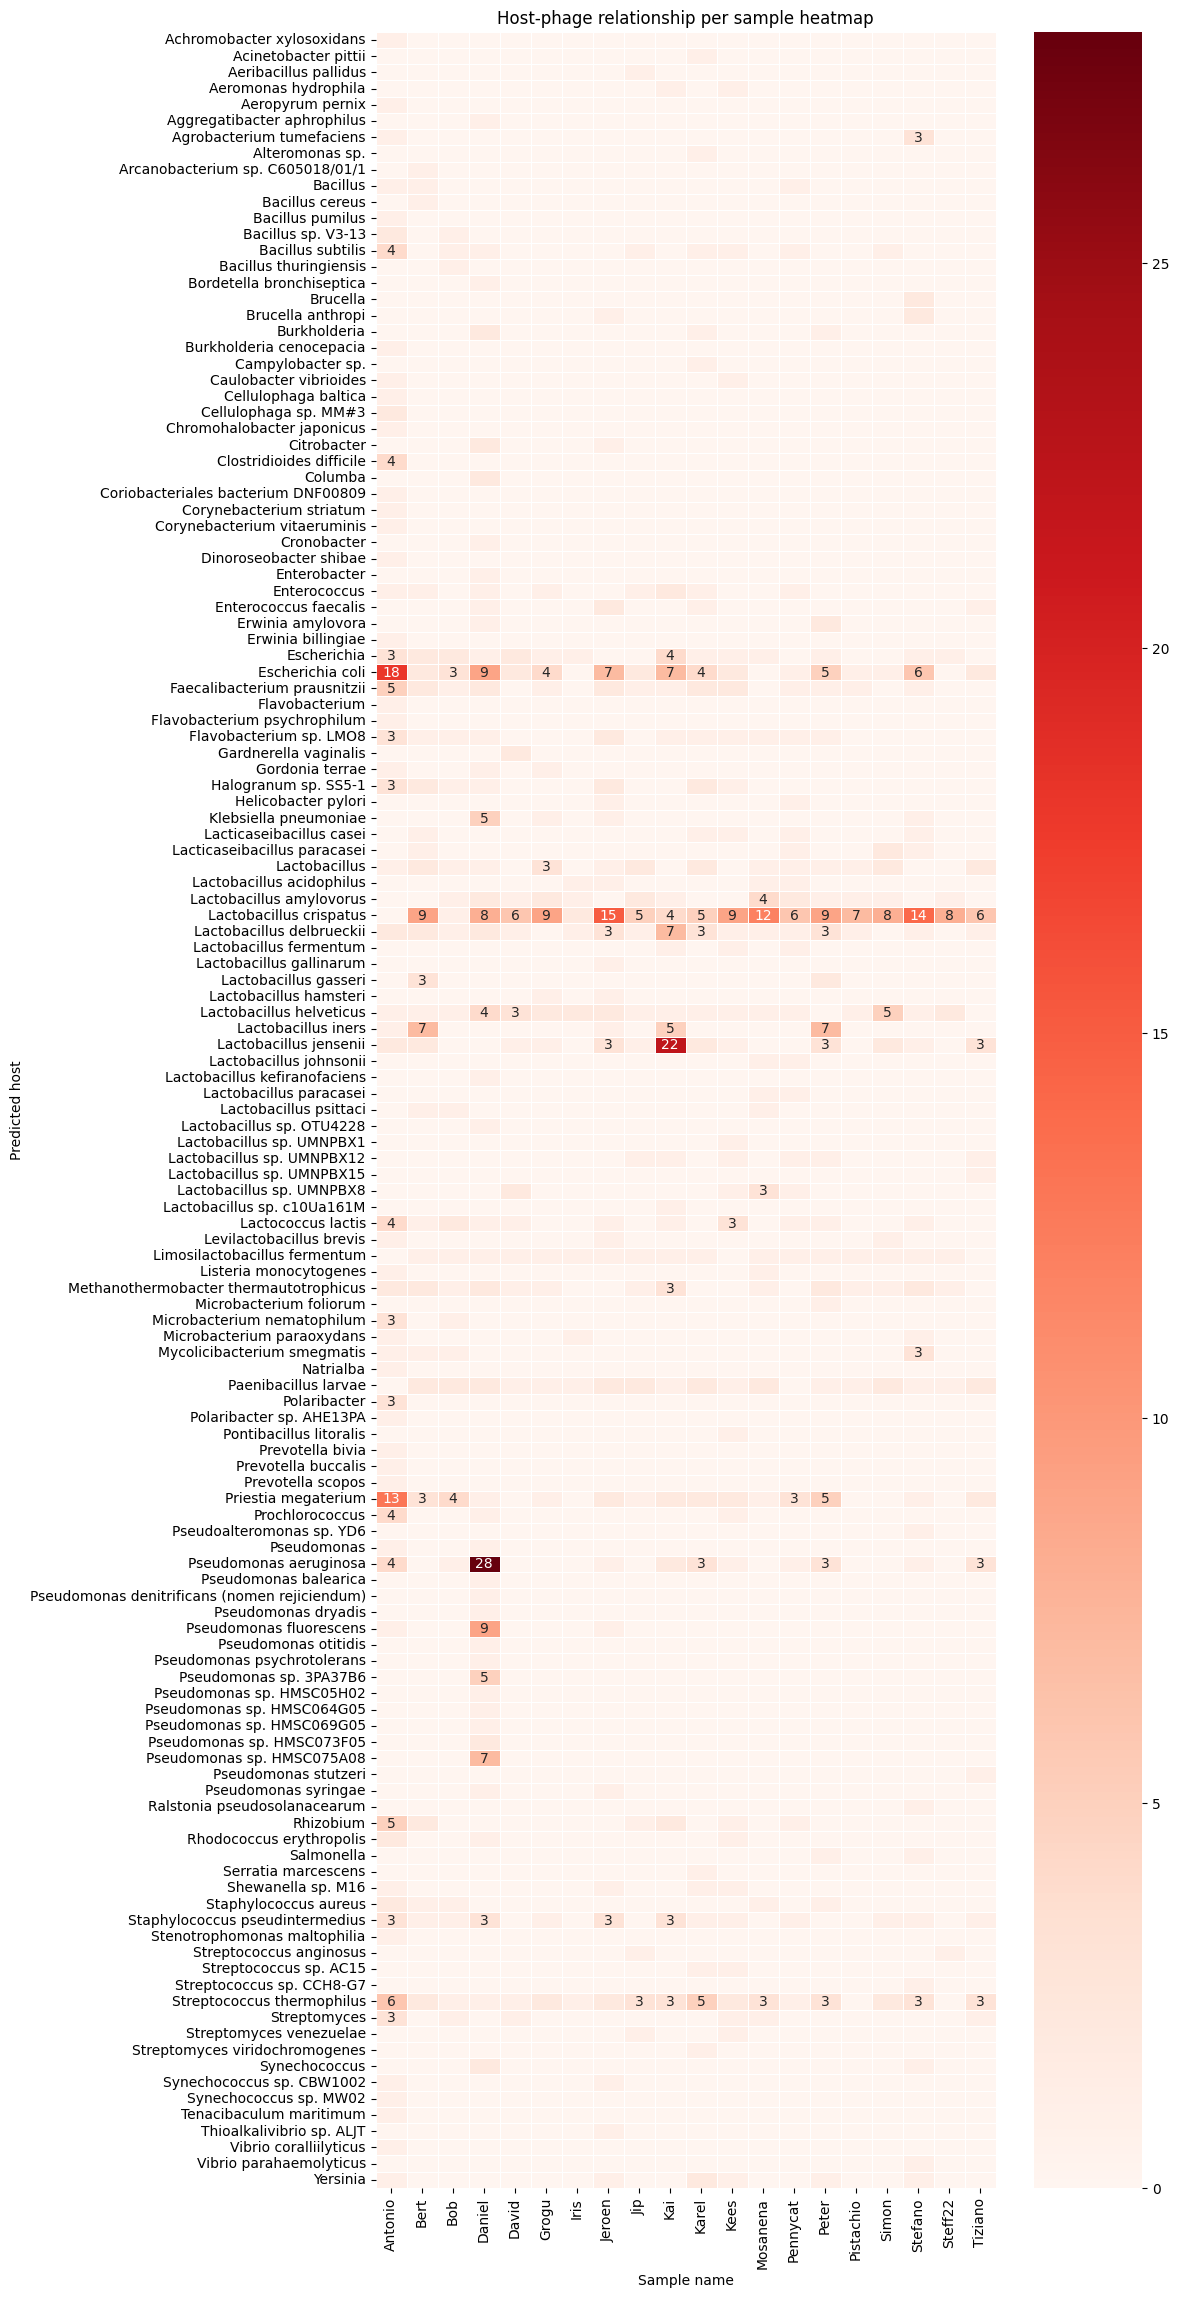

<class 'pandas.core.frame.DataFrame'>
Index: 1603 entries, 154 to 135482
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Accession                                              1603 non-null   object 
 1   Length                                                 1603 non-null   int64  
 2   Pred                                                   1603 non-null   object 
 3   Proportion                                             1603 non-null   float64
 4   PhaMerScore                                            1603 non-null   float64
 5   PhaMerConfidence                                       1603 non-null   object 
 6   Lineage                                                1603 non-null   object 
 7   PhaGCNScore                                            1603 non-null   object 
 8   Genus                                            

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

taxonomy = "Lineage"

# Load the data
df_phage = df_all[(df_all["Prokaryotic virus (Bacteriophages and Archaeal virus)"] == "Y") & 
((df_all["PhaMerConfidence"] == "high-confidence") | (df_all["PhaMerConfidence"] == "medium-confidence"))]
# df_phage = df_all[(df_all["Prokaryotic virus (Bacteriophages and Archaeal virus)"] == "Y") & (df_all["PhaMerConfidence"] == "high-confidence")]
df_phage.loc[:, "Host"] = df_phage.loc[:, "Host"].str.replace('species:','')
df_phage.loc[:, "Host"] = df_phage.loc[:, "Host"].str.replace('genus:','')
df_phage.loc[:, "Lineage"] = df_phage["Lineage"].astype(str).str.split(";").str[-1].str.split(":").str[-1]

# Count of unique viral genera
plt.figure(figsize=(12, 28))
ax = sns.countplot(y=df_phage[taxonomy], hue=df_phage[taxonomy], order=df_phage[taxonomy].value_counts().index, palette="viridis", legend=False)
ax.set_xscale('log')
plt.xlabel("Count")
plt.ylabel("Phage genus")
plt.title("Distribution of bacteriophage genera")
plt.show()

# Phage presence per sample
plt.figure(figsize=(14, 6))
ax = sns.countplot(y=df_phage["sample_name"], hue=df_phage["sample_name"], order=df_phage["sample_name"].value_counts().index,
                   palette="coolwarm", legend=False)

# Annotate bars with Crispatus abundance values
sample_order = df_phage["sample_name"].value_counts().index.tolist()
y_tick_labels = [t.get_text() for t in ax.get_yticklabels()]
y_tick_positions = ax.get_yticks()  # Get the corresponding y positions

# Annotate bars with Crispatus abundance values
for sample_real_name, y_pos in zip(y_tick_labels, y_tick_positions):
    if sample_real_name in crispatus_dict:  # Check if sample has an abundance value
        ax.text(
            ax.get_xlim()[1] + 0.5,  # Position text slightly to the right of the longest bar
            y_pos,  # Corrected y position from tick positions
            f"{crispatus_dict[sample_real_name]:.2f}",  # Format value to 2 decimal places
            ha="left", 
            va="center", 
            fontsize=10, 
            color="black"
        )
plt.xlabel("Count")
plt.ylabel("Sample name")
plt.title("Phage presence per sample")
plt.show()

# Phage-host relationships
plt.figure(figsize=(14, 28))
ax = sns.countplot(y=df_phage["Host"], hue=df_phage["Host"], order=df_phage["Host"].value_counts().index, palette="magma", legend=False)
ax.set_xscale('log')
plt.xlabel("Count")
plt.ylabel("Predicted host")
plt.title("Predicted phage-host relationships")
plt.show()

# Heatmap of phage presence per sample
pivot_table = df_phage.pivot_table(index=taxonomy, columns="sample_name", aggfunc="size", fill_value=0)
plt.figure(figsize=(10, 34))
ax = sns.heatmap(pivot_table, cmap="Blues", linewidths=0.5, annot=True)
for t in ax.texts:
    if float(t.get_text())>=3:
        t.set_text(t.get_text())
    else:
        t.set_text("")

plt.title("Phage presence per sample heatmap")
plt.xlabel("Sample name")
plt.ylabel("Phage genus")
plt.show()

# Heatmap of host-phage relationships per sample
pivot_host_phage = df_phage.pivot_table(index="Host", columns="sample_name", aggfunc="size", fill_value=0)
plt.figure(figsize=(10, 28))
ax = sns.heatmap(pivot_host_phage, cmap="Reds", linewidths=0.5, annot=True)
for t in ax.texts:
    if float(t.get_text())>=3:
        t.set_text(t.get_text())
    else:
        t.set_text("")

plt.title("Host-phage relationship per sample heatmap")
plt.xlabel("Sample name")
plt.ylabel("Predicted host")
plt.show()

df_phage.info()

## Crispatus host only

In [7]:
df_crispatus = df_phage[df_phage["Host"]=="Lactobacillus crispatus"]
df_crispatus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 38857 to 135194
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Accession                                              143 non-null    object 
 1   Length                                                 143 non-null    int64  
 2   Pred                                                   143 non-null    object 
 3   Proportion                                             143 non-null    float64
 4   PhaMerScore                                            143 non-null    float64
 5   PhaMerConfidence                                       143 non-null    object 
 6   Lineage                                                143 non-null    object 
 7   PhaGCNScore                                            143 non-null    object 
 8   Genus                                           

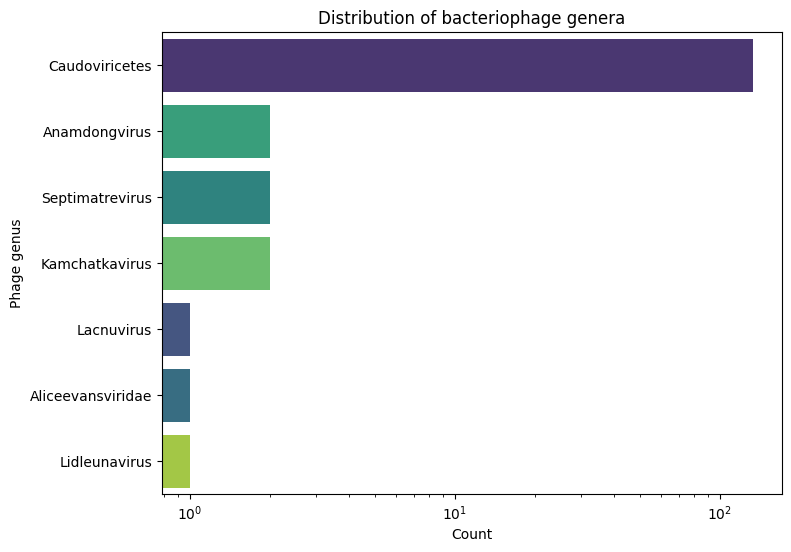

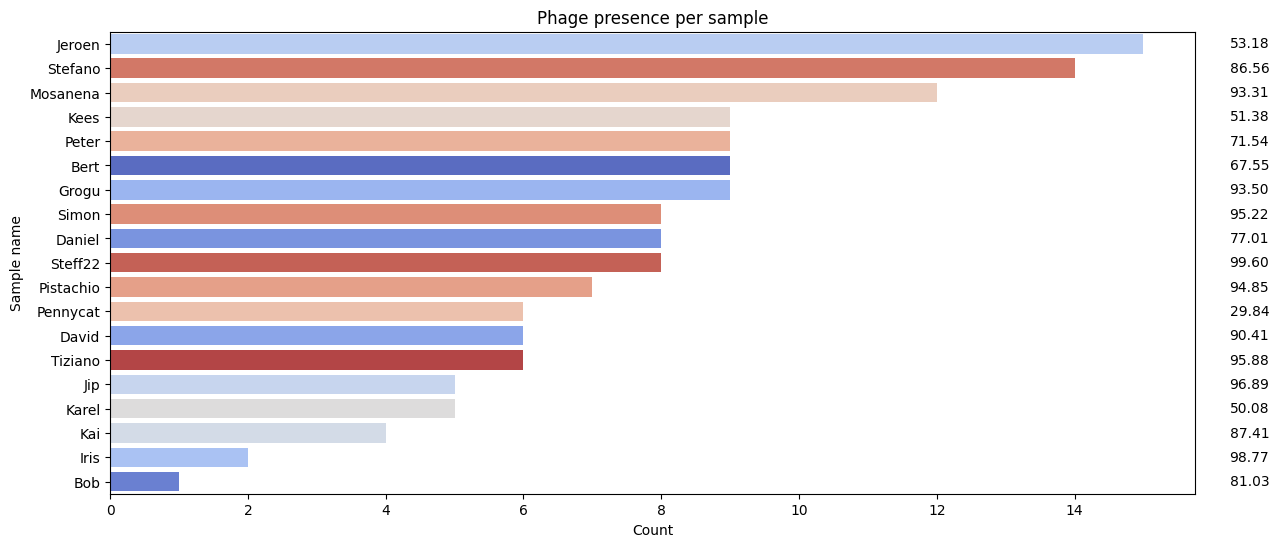

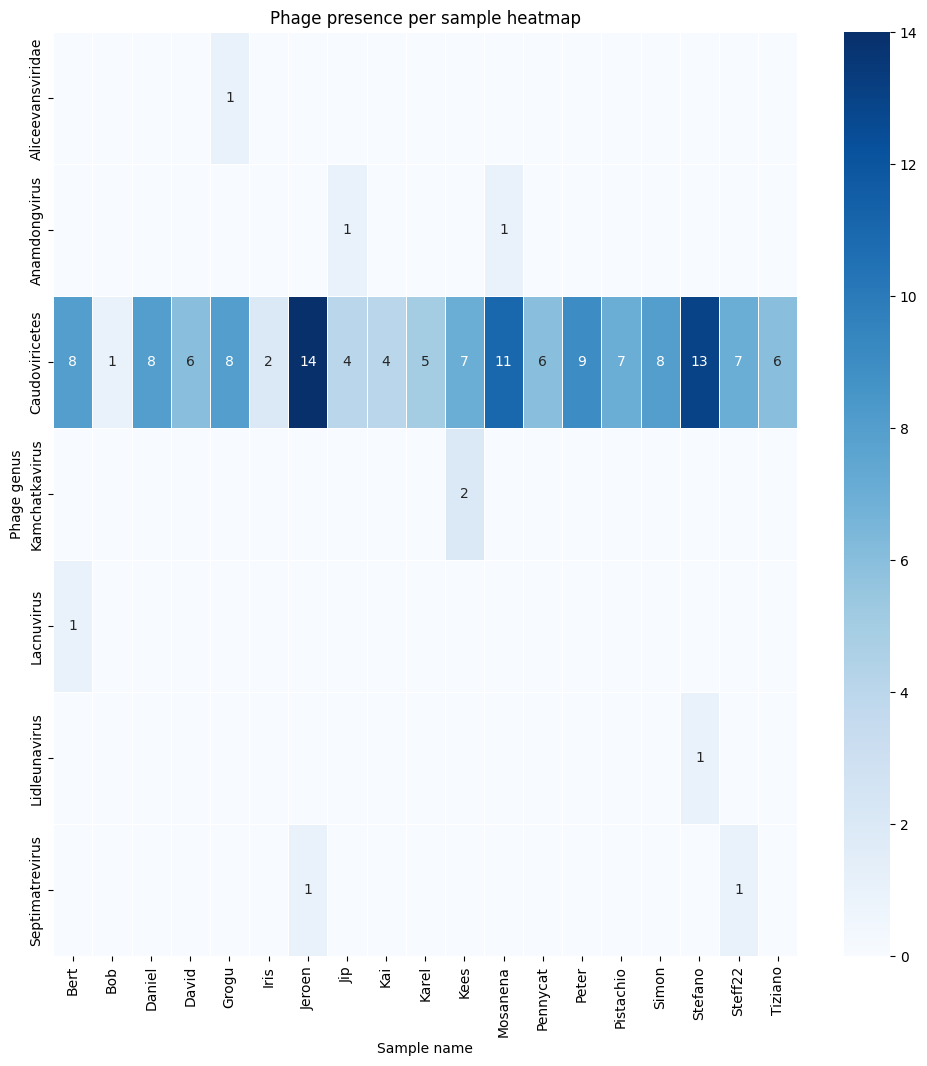

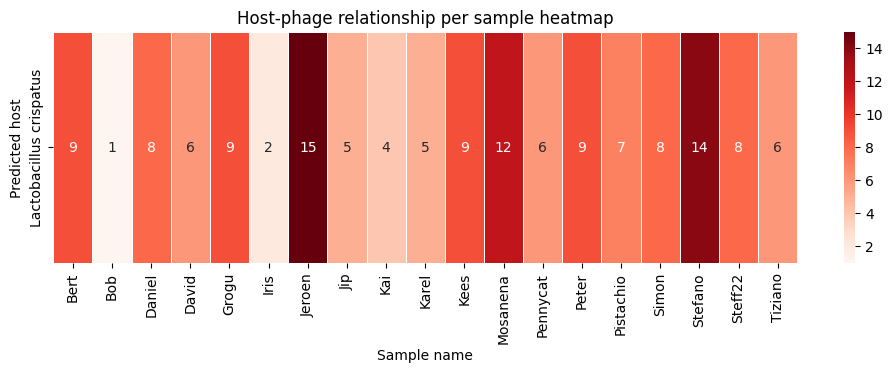

In [8]:
# Count of unique viral genera
plt.figure(figsize=(8, 6))
ax = sns.countplot(y=df_crispatus[taxonomy], hue=df_crispatus[taxonomy], order=df_crispatus[taxonomy].value_counts().index, palette="viridis", legend=False)
ax.set_xscale('log')
plt.xlabel("Count")
plt.ylabel("Phage genus")
plt.title("Distribution of bacteriophage genera")
plt.show()

# Phage presence per sample
plt.figure(figsize=(14, 6))
ax = sns.countplot(y=df_crispatus["sample_name"], hue=df_crispatus["sample_name"], order=df_crispatus["sample_name"].value_counts().index,
                   palette="coolwarm", legend=False)

# Annotate bars with Crispatus abundance values
sample_order = df_crispatus["sample_name"].value_counts().index.tolist()
y_tick_labels = [t.get_text() for t in ax.get_yticklabels()]
y_tick_positions = ax.get_yticks()  # Get the corresponding y positions

# Annotate bars with Crispatus abundance values
for sample_real_name, y_pos in zip(y_tick_labels, y_tick_positions):
    if sample_real_name in crispatus_dict:  # Check if sample has an abundance value
        ax.text(
            ax.get_xlim()[1] + 0.5,  # Position text slightly to the right of the longest bar
            y_pos,  # Corrected y position from tick positions
            f"{crispatus_dict[sample_real_name]:.2f}",  # Format value to 2 decimal places
            ha="left", 
            va="center", 
            fontsize=10, 
            color="black"
        )
plt.xlabel("Count")
plt.ylabel("Sample name")
plt.title("Phage presence per sample")
plt.show()

# Heatmap of phage presence per sample
pivot_table = df_crispatus.pivot_table(index=taxonomy, columns="sample_name", aggfunc="size", fill_value=0)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(pivot_table, cmap="Blues", linewidths=0.5, annot=True)
for t in ax.texts:
    if float(t.get_text())>=1:
        t.set_text(t.get_text())
    else:
        t.set_text("")

plt.title("Phage presence per sample heatmap")
plt.xlabel("Sample name")
plt.ylabel("Phage genus")
plt.show()

# Heatmap of host-phage relationships per sample
pivot_host_phage = df_crispatus.pivot_table(index="Host", columns="sample_name", aggfunc="size", fill_value=0)
plt.figure(figsize=(12, 3))
ax = sns.heatmap(pivot_host_phage, cmap="Reds", linewidths=0.5, annot=True)

plt.title("Host-phage relationship per sample heatmap")
plt.xlabel("Sample name")
plt.ylabel("Predicted host")
plt.show()

In [9]:
df_overview = pd.read_excel("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/overview_table_pres_absence_v2.xlsx")
df_overview.loc[25, "Sample name"] = "Nefesh1_9"
df_overview.loc[:, "Sample basename"] = df_overview["Sample name"].str.split("_").str[0]

df_names = pd.read_csv("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/data/metagenome/metagenome_basesample_names.tsv", sep="\t", index_col="crispatus_name")
df_overview_names = df_overview.set_index("Sample basename").join(df_names)

# Count total phages per sample, unique phage species per sample and binary presence/absence (1 if sample has phage, 0 otherwise)
phage_count = df_crispatus["sample_name"].value_counts().rename("Phage count")
unique_phage_count = df_crispatus.groupby("sample_name")[taxonomy].nunique().rename("Unique phage species")
phage_presence = df_overview_names["metagenome_name"].isin(df_crispatus["sample_name"]).astype(int)
phage_presence = pd.Series(phage_presence.values, index=df_overview_names["metagenome_name"], name="Phage presence").groupby("metagenome_name").mean().astype(int)

# Merge with df_overview
df_merged = df_overview_names.set_index("metagenome_name").join([phage_count, unique_phage_count, phage_presence]).fillna(0).set_index("Sample name")

In [10]:
df_merged

,Glycogen growth prediction,Plasmid,AR & virulence genes,Bacteriocin class I,Bacteriocin class IIa,Bacteriocin class IIb,Bacteriocin class III,CAS-I-E,CAS-II-A,CAS-II-C,...,MucBP domain-containing protein,type IV pilus-like proteins,Putative adhesin domain-containing protein,"GT1, GT2 & GTB",GTA,MGE,Abundance,Phage count,Unique phage species,Phage presence
Sample name,,,,,,,,,,,,,,,,,,,,,
Bella1_1,0.5,1,0,0,1,1,1,0,1,0,...,0,1,1,1,1,0,0.848798,1.0,1.0,1
Bella1_2,0.5,1,0,0,1,0,1,0,1,0,...,0,1,1,1,1,0,0.848798,1.0,1.0,1
Bella1_3,0.5,1,0,0,1,1,1,0,1,0,...,0,1,1,1,1,0,0.848798,1.0,1.0,1
Bella1_4,0.5,1,0,0,0,0,1,0,1,0,...,0,1,1,1,1,0,0.848798,1.0,1.0,1
Bella1_5,1.0,1,0,0,1,0,1,0,1,0,...,0,1,1,1,1,0,0.848798,1.0,1.0,1
Bella1_6,0.5,1,0,0,1,1,1,0,1,0,...,0,1,1,1,1,0,0.848798,1.0,1.0,1
Bella1_7,0.5,1,0,0,1,0,1,0,1,0,...,0,1,1,1,1,0,0.848798,1.0,1.0,1
Campanarius1_1,1.0,1,0,0,1,0,1,0,1,0,...,0,1,1,0,0,0,0.662561,0.0,0.0,0
Campanarius1_2,1.0,1,0,0,1,0,1,0,1,0,...,0,1,1,0,0,0,0.662561,0.0,0.0,0


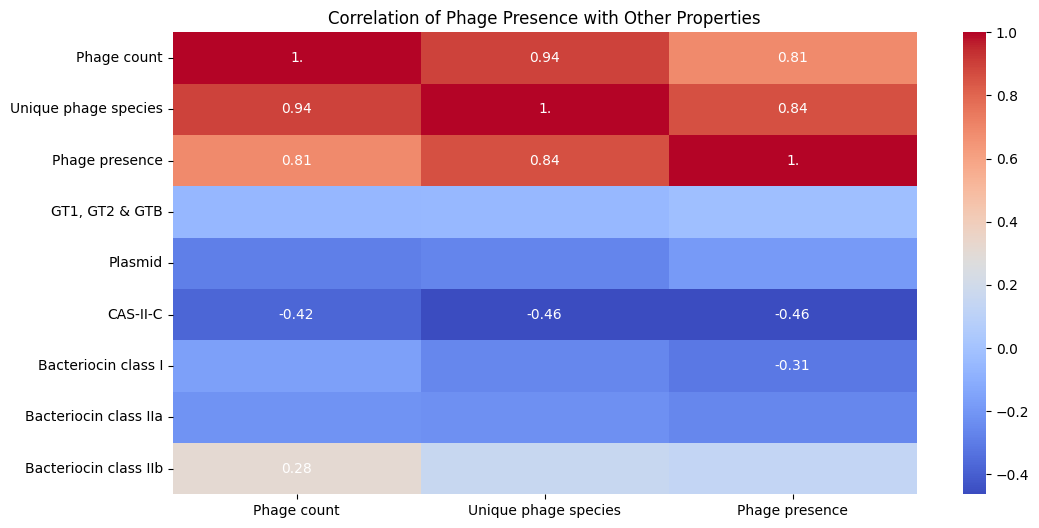

In [18]:
import numpy as np
# df_merged_filtered = df_merged[["Phage count", "Unique phage species", "Phage presence", "GT1", "oriC", 'cas1', 'cas2', 'cas3', 'cas5', 'cas6', 'cas7',
#        'cas8', 'cas9', 'cas10', 'cas11', 'cas12', 'cmr5', 'csa3', 'cse2',
#        'csm2', 'csm6', 'csn2', 'csx1', 'csx3', 'csx19', 'csx21', 'DinG']]
pd.options.display.precision = 2
df_merged_filtered = df_merged[["Phage count", "Unique phage species", "Phage presence", "GT1, GT2 & GTB", "Plasmid", "CAS-II-C", "Bacteriocin class I",
                                "Bacteriocin class IIa", "Bacteriocin class IIb"]]

correlation_matrix = df_merged_filtered.corr()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(correlation_matrix[["Phage count", "Unique phage species", "Phage presence"]], 
            annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Phage Presence with Other Properties")

for i in correlation_matrix[["Phage count", "Unique phage species", "Phage presence"]].index:
    for j in correlation_matrix[["Phage count", "Unique phage species", "Phage presence"]].columns:
        if df_corr[(df_corr["Feature_1"] == i) & (df_corr["Feature_2"] == j)]["p_value"].values[0] < 0.05:
            text = ax.text(correlation_matrix[["Phage count", "Unique phage species", "Phage presence"]].columns.get_loc(j) + 0.5, 
                           correlation_matrix[["Phage count", "Unique phage species", "Phage presence"]].index.get_loc(i) + 0.5, 
                           f"{np.format_float_positional(df_corr[(df_corr["Feature_1"] == i) & (df_corr["Feature_2"] == j)]["Correlation"].values[0], precision=2)}",
                           ha="center", va="center", color="w")

plt.savefig("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/phages/correlation_heatmap.png")
plt.show()

In [12]:
import scipy

df_corr = pd.DataFrame()
feat1s = []
feat2s = []
corrs = []
p_values = []

for feat1 in df_merged_filtered.columns:
    for feat2 in ["Phage count", "Unique phage species", "Phage presence"]:
        # if feat1 != feat2:
        feat1s.append(feat1)
        feat2s.append(feat2)
        corr, p_value = scipy.stats.spearmanr(df_merged_filtered[feat1], df_merged_filtered[feat2])
        corrs.append(corr)
        p_values.append(p_value)

df_corr['Feature_1'] = feat1s
df_corr['Feature_2'] = feat2s
df_corr['Correlation'] = corrs
df_corr['p_value'] = p_values
display(df_corr)

df_corr[(df_corr["Feature_1"] == "Phage count") & (df_corr["Feature_2"] == "Phage count")]["p_value"].values

df_corr.style.format({'p_value': '{:.2f}'})

,Feature_1,Feature_2,Correlation,p_value
0,Phage count,Phage count,1.00,0.00e+00
1,Phage count,Unique phage species,0.94,1.40e-25
2,Phage count,Phage presence,0.81,2.13e-13
3,Unique phage species,Phage count,0.94,1.40e-25
4,Unique phage species,Unique phage species,1.00,0.00e+00
5,Unique phage species,Phage presence,0.84,1.82e-15
6,Phage presence,Phage count,0.81,2.13e-13
7,Phage presence,Unique phage species,0.84,1.82e-15
8,Phage presence,Phage presence,1.00,0.00e+00
9,"GT1, GT2 & GTB",Phage count,-0.02,8.79e-01


,Feature_1,Feature_2,Correlation,p_value
0,Phage count,Phage count,1.000000,0.00
1,Phage count,Unique phage species,0.940600,0.00
2,Phage count,Phage presence,0.809678,0.00
3,Unique phage species,Phage count,0.940600,0.00
4,Unique phage species,Unique phage species,1.000000,0.00
5,Unique phage species,Phage presence,0.844870,0.00
6,Phage presence,Phage count,0.809678,0.00
7,Phage presence,Unique phage species,0.844870,0.00
8,Phage presence,Phage presence,1.000000,0.00
9,"GT1, GT2 & GTB",Phage count,-0.021444,0.88


In [ ]:
df_corr[df_corr["Feature_1"] == "oriC"]

In [ ]:
correlation_matrix[["Phage count", "Unique phage species", "Phage presence"]].index